In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import scipy
import scipy.ndimage.filters
import os
import time

In [38]:
#Load all four momenta
print("Load data")
data_store = pandas.HDFStore("train.h5")
print("Data loaded")

Load data
Data loaded


In [39]:
# Plots 3 images, the original, the adversarial and the difference between both
def plotter(image, perturbed, name):
    
    signal = image
    signal = signal[0][0]
    
    image_perturbed = perturbed
    image_perturbed = image_perturbed[0][0]
    
    differ = np.absolute(image - perturbed)
    differ = differ[0][0]
    
    fig, axs = plt.subplots(1, 3,figsize=(40,40))
    plt.rcParams.update({'font.size': 25}) #Larger font size

    original = axs[0].imshow(signal,cmap="Reds")
    fig.colorbar(original, ax=axs[0], shrink=0.25)
    
    pertubed = axs[1].imshow(image_perturbed,cmap="Reds")
    fig.colorbar(pertubed, ax=axs[1], shrink=0.25)
    
    diffpic = axs[2].imshow(differ,cmap="Reds")
    fig.colorbar(diffpic, ax=axs[2], shrink=0.25)
    
    for ax in axs.flat:
        ax.set(xlabel='$\eta$', ylabel='$\phi$')
        
    plt.savefig(f'{name}.png',format='png')
    plt.show()

In [40]:
def plotone(image): #Plots one image
    signal = image
    signal = signal[0][0]
    
    fig, axs = plt.subplots(1, 1,figsize=(40,40))
    plt.rcParams.update({'font.size': 25}) #Larger font size

    original = axs.imshow(signal,cmap="Reds")
    fig.colorbar(original, ax=axs)
    axs.set(xlabel='$\eta$', ylabel='$\phi$')
    
    plt.show()

In [41]:
# calculate pseudorapidity of pixel entries
def eta(pT, pz):
    small = 1e-10

    small_pT = (np.abs(pT) < small)
    small_pz = (np.abs(pz) < small)
    not_small = ~(small_pT | small_pz)

    theta = np.arctan(pT[not_small]/pz[not_small])
    theta[theta < 0] += np.pi

    etas = np.zeros_like(pT)
    etas[small_pz] = 0
    etas[small_pT] = 1e-10
    etas[not_small] = np.log(np.tan(theta/2))
    return etas

#calculate phi (in range [-pi,pi]) of pixel entries
def phi(px, py):
    ''' phis are returned in rad., np.arctan(0,0)=0 -> zero constituents set to -np.pi
    '''
    phis = np.arctan2(py,px)
    phis[phis < 0] += 2*np.pi
    phis[phis > 2*np.pi] -= 2*np.pi
    phis = phis - np.pi
    return phis

#put eta-phi entries on grid
def orig_image(etas,phis,es):
    ''' gives always the larger value on the grid, eg. for xpixel = (0,1,2,3,..)  eta=1.3 -> xpixel=2,
    np.argmax gives position of first True value in array
    '''
    z = np.zeros((etas.shape[0],len(xpixels),len(ypixels)))
    in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
    xcoords = np.argmax(etas[:,None,:] < xpixels[None,:,None],axis=1)
    ycoords = np.argmax(phis[:,None,:] < ypixels[None,:,None],axis=1)
    ncoords = np.repeat(np.arange(etas.shape[0])[:,None],etas.shape[1],axis=1)
    z[ncoords[in_grid],ycoords[in_grid],xcoords[in_grid]] = es[in_grid]

    return z

#put eta-phi entries on grid
def orig_image2(etas,phis,es):
    ''' Alternative version of orig_image: Gives the value on grid with minimal distance,
    eg. for xpixel = (0,1,2,3,..) eta=1.3 -> xpixel=1, eta=1.6 ->xpixel=2
    '''
    z = np.zeros((etas.shape[0],len(xpixels),len(ypixels)))
    in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
    xcoords = np.argmin(np.abs(etas[:,None,:] - xpixels[None,:,None]),axis=1)
    ycoords = np.argmin(np.abs(phis[:,None,:] - ypixels[None,:,None]),axis=1)
    ncoords = np.repeat(np.arange(etas.shape[0])[:,None],etas.shape[1],axis=1)
    z[ncoords[in_grid],ycoords[in_grid],xcoords[in_grid]] = es[in_grid]

    return z

def orig_image3(etas, phis, es):
    '''CORRECTED version of orig_image! summing intensities up instead of
    just overwriting
    Note: Don't worry about the loop. Doesn't really slow the whole
    thing done. I tried to do it fully with numpy arrays by introducing
    a 4th axis in z and summing over it, but memory arrays appearing
    for small batch_sizes and it makes everything quite slow.
    Args:
        etas: 2d array of shape [n_events, n_constit]
        phis: 2d array of same shape as etas
        es: 2d array of same shape as etas; will be the pixel
            intensities; pt can be choosen as well
    Return:
        2d grid-array with entries = es
    '''

    n_events = etas.shape[0]
    n_constit = etas.shape[1]

    z = np.zeros((n_events, len(xpixels), len(ypixels)))
    for i in range(n_constit):

        etas_i = etas[:, i]
        phis_i = phis[:, i]
        es_i = es[:, i]

        in_grid = ~((etas_i < xpixels[0]) | (etas_i > xpixels[-1]) | (phis_i < ypixels[0]) | (phis_i > ypixels[-1]))
        xcoords = np.argmax(etas_i[:,None] < xpixels[None,:],axis=1)
        ycoords = np.argmax(phis_i[:,None] < ypixels[None,:],axis=1)
        ncoords = np.arange(n_events)

        z[ncoords[in_grid], ycoords[in_grid], xcoords[in_grid]] += es_i[in_grid]

    return z


def print_time(msg):
    print("[%8.2f] %s"%(time.time()-time_start,msg))

def img_mom(x, y, weights, x_power, y_power):
    '''returns image momenta for centroid and principal axis'''
    return ((x**x_power)*(y**y_power)*weights).sum()

def preprocessing(x ,y, weights):
    ''' (x,y) are the coordinates and weights the corresponding values, shifts
    centroid to origin, rotates image, so that principal axis is vertical,
    flips image, so that most weights lay in (x<0, y>0)-plane.
    Method for calculating principal axis (similar to tensor of inertia):
    https://en.wikipedia.org/wiki/Image_moment
    here: y=phi, phi has modulo 2*np.pi but it's not been taken care of hear,
    so possible issues with calculating the centroid
    -> pre-shifting of events outside of this function solves the problem
    for iamge-data with Delta_phi(jet) << 2*np.pi
    '''

    # shift
    x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
    y_centroid = img_mom(x, y, weights, 0, 1)/ weights.sum()
    print(f'Control Eta_centroid = {x_centroid}, Phi_centroid = {y_centroid}')
    x = x - x_centroid
    y = y - y_centroid

    # check if shifting worked, there can be problems with modulo variables like phi (y)
    # x and y are sorted after highest weight, 0-comp. gives hottest event
    # for Jet-like Images Centroid should be close to hottest constituen (pT-sorted arrays)
    global n_shift_phi
    global n_shift_eta
    if np.abs(x[0]) > n_warning:
        n_shift_eta += 1
    if np.abs(y[0]) > n_warning:
        n_shift_phi += 1

    if Rotate:
        # covariant matrix, eigenvectors corr. to principal axis
        u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
        u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
        u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
        cov = np.array([[u20, u11], [u11, u02]])

        # Eigenvalues and eigenvectors of covariant matrix
        evals, evecs = np.linalg.eig(cov)

        # sorts the eigenvalues, v1, [::-1] turns array around,
        sort_indices = np.argsort(evals)[::-1]
        e_1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        e_2 = evecs[:, sort_indices[1]]

        # theta to x_asix, arctan2 gives correct angle
        theta = np.arctan2(e_1[0], e_1[1])

        # rotation, so that princple axis is vertical
        # anti-clockwise rotation matrix
        rotation = np.matrix([[np.cos(theta), -np.sin(theta)],
                             [np.sin(theta), np.cos(theta)]])
        transformed_mat = rotation * np.stack([x,y])
        x_rot, y_rot = transformed_mat.A
    else:
        x_rot, y_rot = x, y

    # flipping
    n_flips = 0
    if Flip:
        if weights[x_rot<0.].sum() < weights[x_rot>0.].sum():
            x_rot = -x_rot
            n_flips  += 1
        if weights[y_rot<0.].sum() > weights[y_rot>0.].sum():
            y_rot = -y_rot
            n_flips += 1

    #print('number of flips: ' + str(n_flips))

    return x_rot, y_rot

def mass(E,px,py,pz):
    '''Calculating the invariant mass of the total momentum of all
    constituents, negative massses can occure! -> is set to 0'''
    mass2 = E**2-px**2-py**2-pz**2
    mass2 = np.maximum(0.,mass2)
    mass = np.sqrt(mass2)
    return mass


def process_batch(start_id):
    print_time("Loading input file (events %i to %i)"%(start_id+batch_number*batch_size,start_id+(1+batch_number)*batch_size))
    df = data_store.select('table',start=start_id+batch_number*batch_size,stop=start_id+(1+batch_number)*batch_size)
    if df.shape[0] == 0:
        return False

    print_time("Extracting 4-vectors")
    feat_list =  ["E","PX","PY","PZ"]
    cols = ["{0}_{1}".format(feature,constit)
            for feature in feat_list for constit in range(n_constit)]
    vec4 = np.expand_dims(df[cols],axis=-1).reshape(-1, len(feat_list), n_constit)
    isig = df[signal_col]

    print_time("Calculating pT")
    E     = vec4[:,0,:]
    pxs   = vec4[:,1,:]
    pys   = vec4[:,2,:]
    pzs   = vec4[:,3,:]
    pT    = np.sqrt(pxs**2+pys**2)

    print_time("Calculating eta")
    etas  = eta(pT,pzs)
    print_time("Calculating phi")
    phis  = phi(pxs,pys)

    print_time("Calculating the mass")
    E_tot = E.sum(axis=1)
    px_tot = pxs.sum(axis=1)
    py_tot = pys.sum(axis=1)
    pz_tot = pzs.sum(axis=1)
    j_mass = mass(E_tot, px_tot, py_tot, pz_tot)

    #pre-shifting of phi
    phis = (phis.T - phis[:,0]).T
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi

    print_time("Preprocessing")
    if intensity == "pT":
        weights = pT
    elif intensity == "E":
        weights = E

    if Shift==True:
        for i in np.arange(0,batch_size):
            etas[i,:], phis[i,:] = preprocessing(etas[i,:], phis[i,:], weights[i,:])

    # using pT instead of energy E
    print_time("Creating images")
    z_ori = orig_image3(etas, phis, weights)

    # normalize
    print_time("Normalize")
    z_new = np.zeros((z_ori.shape[0],n_pixel, n_pixel))
    if Norm:
        for i in range(z_ori.shape[0]):
            z_sum = z_ori[i,:,:].sum()
            if z_sum != 0.:
                z_new[i,:,:] = z_ori[i,:,:]/z_sum
    else:
        z_new = z_ori

    print_time("Reshaping output")
    z_out = z_new.reshape((z_new.shape[0],-1))

    print_time("Creating output dataframe")
    out_cols = (["img_{0}".format(i) for i in range(z_new.shape[1]*z_new.shape[2])]
                + [signal_col] +[mass_col])
    df_out = pandas.DataFrame(data=np.concatenate((z_out,isig[:,None],j_mass[:,None]),axis=1),
                              index=np.arange(start_id,start_id+batch_size),
                              columns=out_cols)
    print_time("Writing output file")
    if os.path.isfile("original.h5"):
        os.remove("original.h5")
    df_out.to_hdf("original.h5",'table',append=(start_id!=0),format='table',complib = "blosc", complevel=5)

    return True

In [42]:
# Info:
# input should include E, PX, PY and PZ column to work
# n_constit should be sorted by pT, highest pT first, but code should work in principal with
# unsorted data (except the debugging 2 will give wrong warnings))
#
# problem with panda if n_pixel to large! 64kb limit for column,
# roughly 2000 columns possible, 59*59 pixels was still possible for me
#
# be carefull about meaning of x and y, x is eta and phi is y
#
# Changes:
# included (complib = "blosc", complevel=5) to to_hdf
# included mass, corrected for negative values give 0
# included assert outputfile

########################################
# Settings
########################################

a = 600021 #0, 600020, 600024 hat sehr gut funktioniert, 600021, 600025 solala
b = a+1 #With a and b you choose which event to preprocess

# input/output settings
signal_col  = "is_signal_new"
mass_col    = "mass"
n_constit   = 200
batch_size  = 1
start_number = a
end_number = b
event_number = end_number - start_number
intensity = "pT"  # or "E" what to use for filling images
n_pixel = 40

# image preprocessing options
#Rotate, Flip, Shift, Norm  = True, True, True, True  # full preprocessing
Rotate, Flip, Shift, Norm  = False, False, True, True # minimal preprocessing with norm
#Rotate, Flip, Shift, Norm  = False, False, False, True # Only norm

max_batches = float(event_number)/batch_size

# grid settings
xpixels = np.linspace(-0.58, 0.58, n_pixel)
ypixels = np.linspace(-0.7, 0.7, n_pixel)

#ypixels = np.linspace(-1.745, 1.745, n_pixel)
#xpixels = np.linspace(-2, 2, n_pixel)


#########################################

# probably doesn't need a square grid any longer?
assert len(xpixels) == len(ypixels), "need a square grid"

# check if hottest constituent is close to centre afer shifting
# value depends on jet-radius of the jets
# just for debugging, consistency check, can be ignored
n_warning = 0.7

##################################




#--------------------------------------------------------------

#print Settings
print("----------------------------------------------------")
print("number of x_pixel (eta): " + str(len(xpixels)))
print("number of y_pixel (phi): " + str(len(ypixels)))
print("x_min, x_max (eta): {0:4.2f} {1:4.2f}".format(xpixels.min(), xpixels.max()))
print("y_min, y_max (phi): {0:4.2f} {1:4.2f}".format(ypixels.min(), ypixels.max()))
print("x: step_size (eta): {0:5.3f}".format(xpixels[1]-xpixels[0]))
print("y: step_size (phi): {0:5.3f}".format(ypixels[1]-ypixels[0]))
print("signal_col  = " + signal_col)
print("mass_col    = " + mass_col)
print("n_constit   = " + str(n_constit))
print("batch_size  = " + str(batch_size))
print("number of events = " + str(event_number))
print("Rotate, Flip, Norm  = " + str(Rotate)+ " " + str(Flip) +  " " +str(Norm))
print("For intenisty of pixel used: " + intensity)
print("Output-images: {0}x{0} pixel with range: eta = {1:4.2f}, phi = {2:4.2f}".format(n_pixel, xpixels.max()-xpixels.min(), ypixels.max()-ypixels.min()))
print("---------------------------------------------------")

time_start = time.time()
batch_number = 0
n_shift_phi = 0         # number of times shifting failed
n_shift_eta = 0


while process_batch(start_number):
    batch_number += 1
    if batch_number == max_batches:
        break

if n_shift_eta != 0:
    print_time("Warning: hottest constituent is supposed to be close to origin.")
    print_time("Number of times eta of hottest const. was not close to origin: " + str(n_shift_eta))
if n_shift_phi != 0:
    print_time("Warning: hottest constituent is supposed to be close to origin.")
    print_time("Number of times phi of hottest const. was not close to origin: " + str(n_shift_phi))

print_time("Finished preprocessing")

----------------------------------------------------
number of x_pixel (eta): 40
number of y_pixel (phi): 40
x_min, x_max (eta): -0.58 0.58
y_min, y_max (phi): -0.70 0.70
x: step_size (eta): 0.030
y: step_size (phi): 0.036
signal_col  = is_signal_new
mass_col    = mass
n_constit   = 200
batch_size  = 1
number of events = 1
Rotate, Flip, Norm  = False False True
For intenisty of pixel used: pT
Output-images: 40x40 pixel with range: eta = 1.16, phi = 1.40
---------------------------------------------------
[    0.00] Loading input file (events 600021 to 600022)
[    0.02] Extracting 4-vectors
[    0.02] Calculating pT
[    0.02] Calculating eta
[    0.02] Calculating phi
[    0.02] Calculating the mass
[    0.02] Preprocessing
Control Eta_centroid = 0.041166674345731735, Phi_centroid = 0.13768911361694336
[    0.02] Creating images
[    0.03] Normalize
[    0.03] Reshaping output
[    0.03] Creating output dataframe
[    0.03] Writing output file
[    0.05] Finished preprocessing


Data Prepararing Begin
Data Prepararing Finished
[1.]


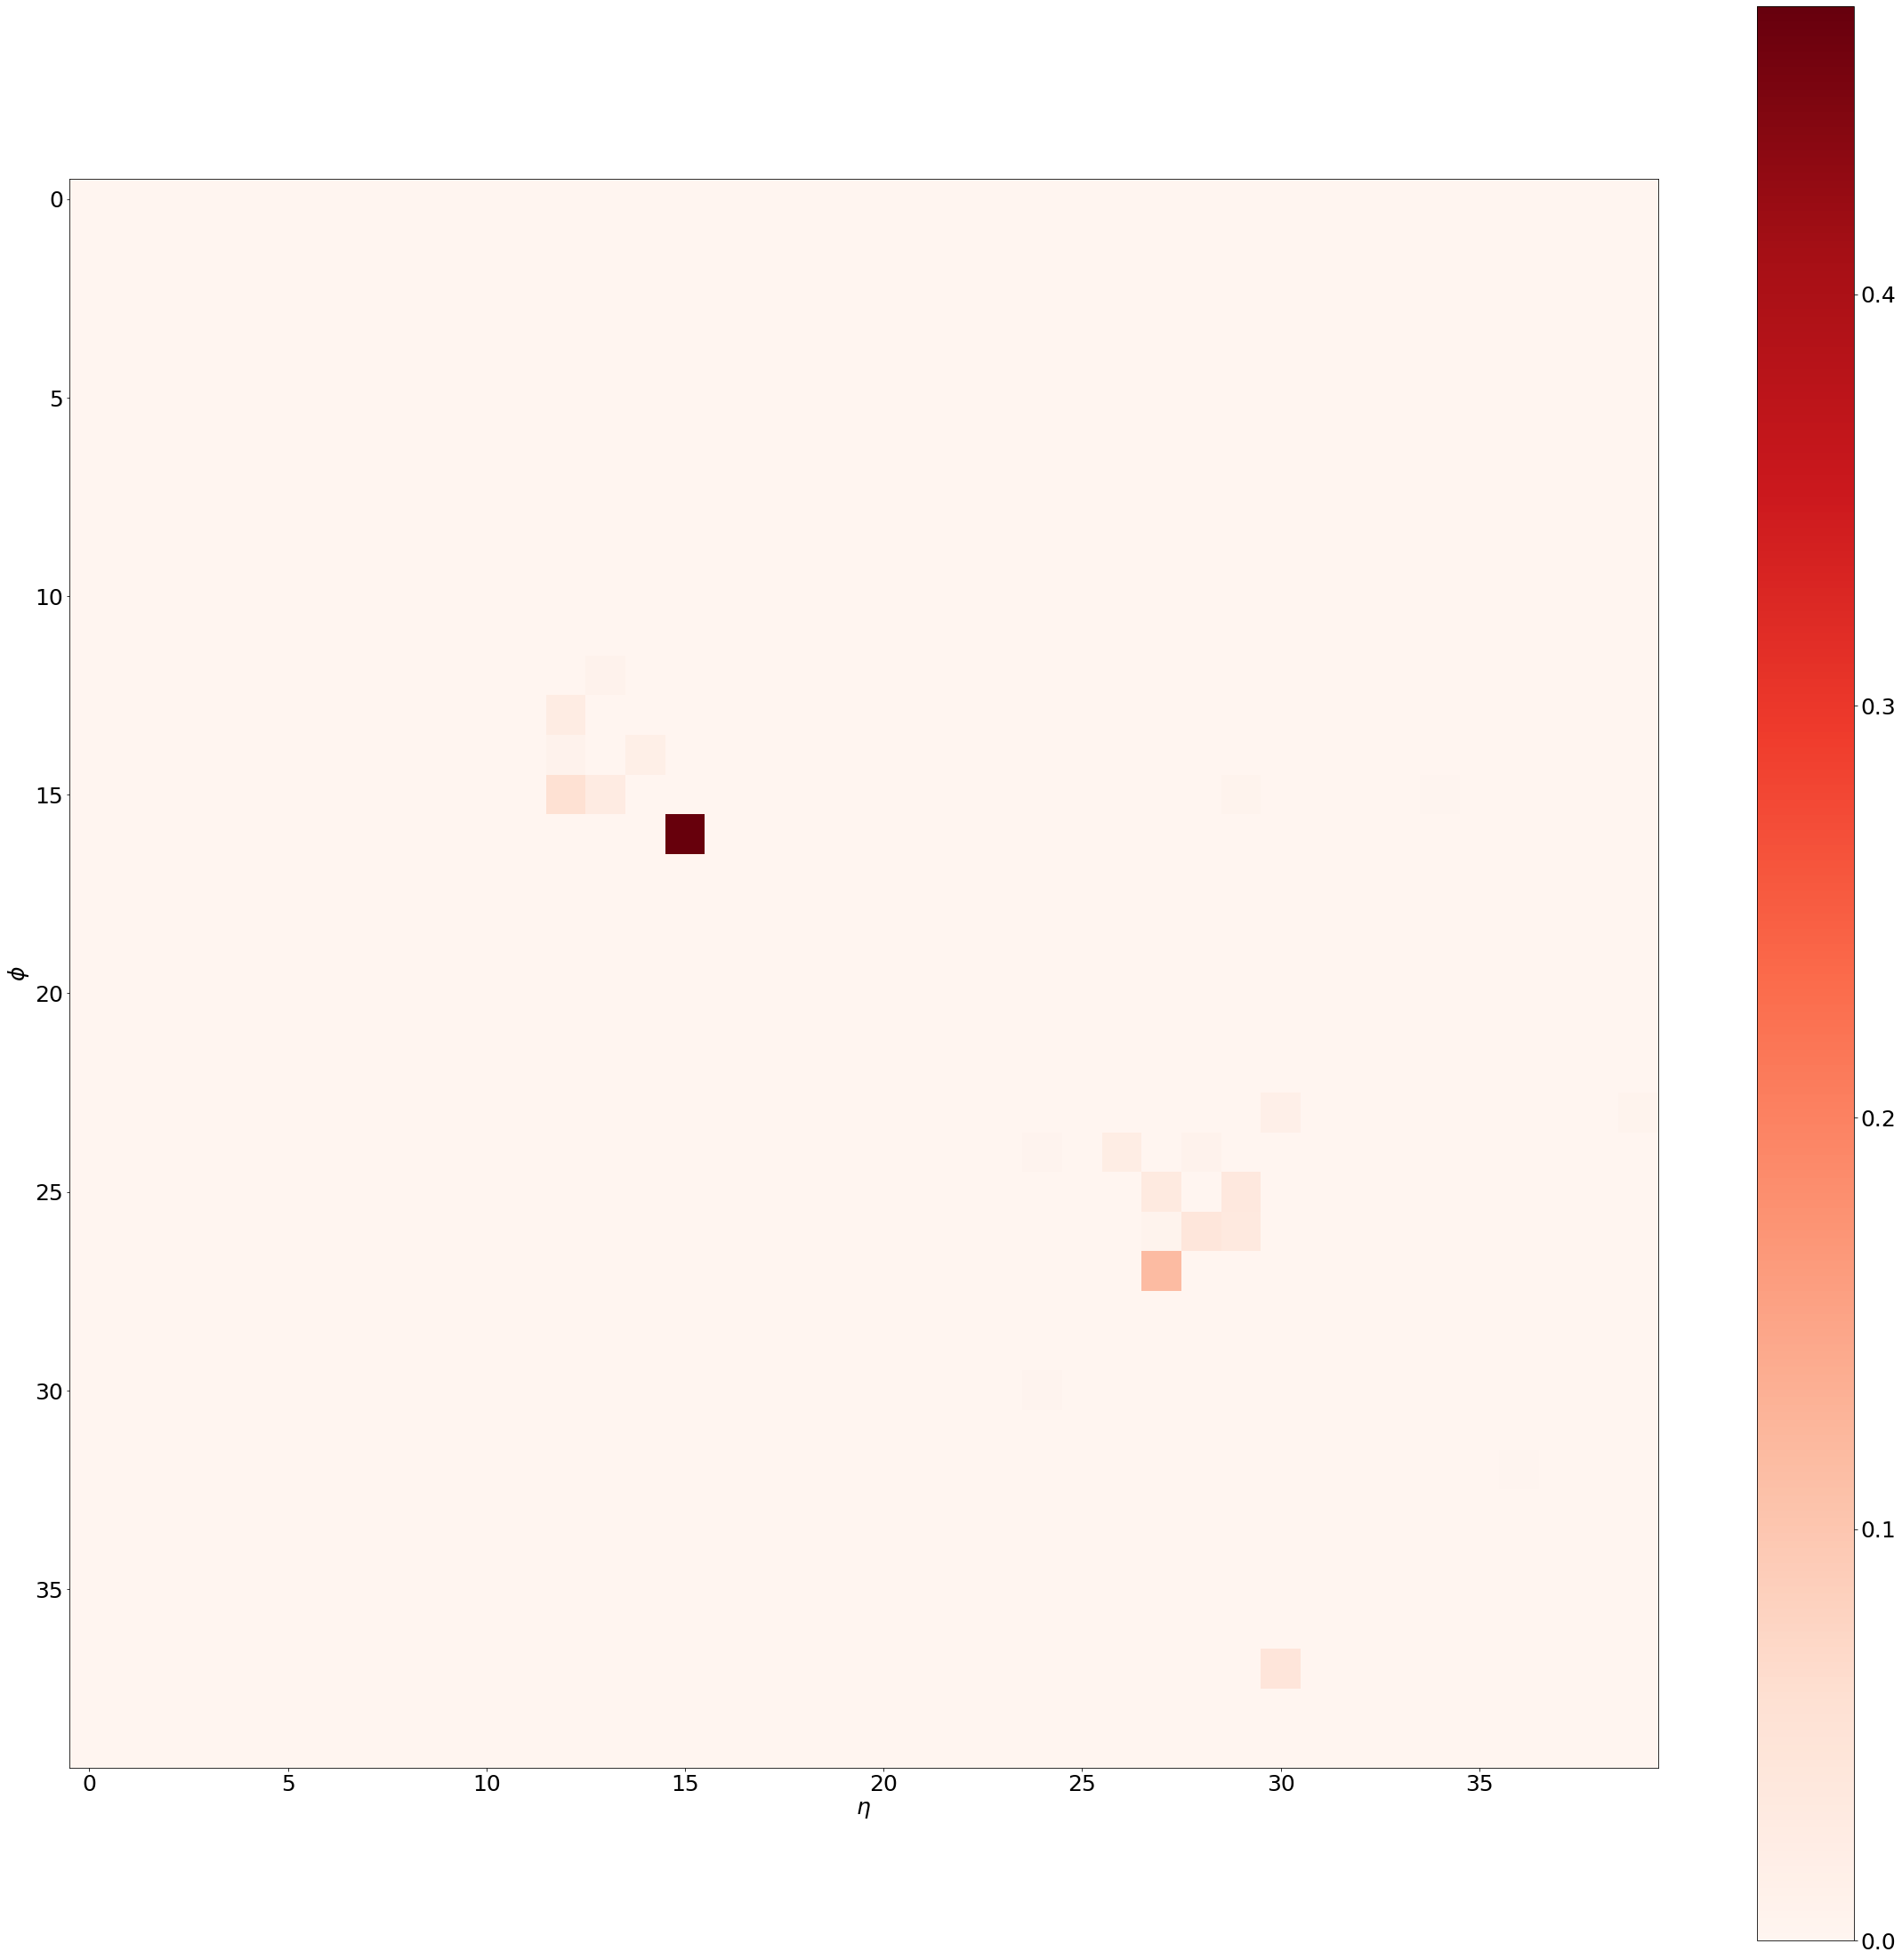

In [43]:
#Function for data prepraration
pixels = ["img_{0}".format(i) for i in range(1600)]

def to_image(df):
    return  np.expand_dims(np.expand_dims(df[pixels], axis=-1).reshape(-1,40,40), axis=1)

#Load preprocessed data
print("Data Prepararing Begin")
store_original_images = pandas.HDFStore("original.h5")
df_original_images = store_original_images.select("table")
    
images_original = to_image(df_original_images) #Store images
images_original_labels = df_original_images["is_signal_new"].to_numpy() #Store true scores

print("Data Prepararing Finished")

X_original = images_original
y_original = images_original_labels
print(y_original)
plotone(images_original)

In [44]:
# process_adversarials like process_batch. but it produces adversarial preprocessed data
# Function has to be tuned, because it only works for batch_size=1
def process_adversarials(start_id, j, Eta, Phi, Hack): #j=Choose constitute, Eta, Phi = Choose eta and phi of constitute
    df = data_store.select('table',start=start_id+batch_number*batch_size,stop=start_id+(1+batch_number)*batch_size)
    if df.shape[0] == 0:
        return False
    
    feat_list =  ["E","PX","PY","PZ"]
    cols = ["{0}_{1}".format(feature,constit)
            for feature in feat_list for constit in range(n_constit)]
    vec4 = np.expand_dims(df[cols],axis=-1).reshape(-1, len(feat_list), n_constit)
    isig = df[signal_col]

    E     = vec4[:,0,:]
    pxs   = vec4[:,1,:]
    pys   = vec4[:,2,:]
    pzs   = vec4[:,3,:]
    pT    = np.sqrt(pxs**2+pys**2)
    pt = pT[0][j]

    etas  = eta(pT,pzs)
    phis  = phi(pxs,pys)
    
    initial_eta = etas[0][j]
    initial_phi = phis[0][j]
    initial_pT = pT[0][j]

    E_tot = E.sum(axis=1)
    px_tot = pxs.sum(axis=1)
    py_tot = pys.sum(axis=1)
    pz_tot = pzs.sum(axis=1)
    j_mass = mass(E_tot, px_tot, py_tot, pz_tot)

    #pre-shifting of phi
    phis = (phis.T - phis[:,0]).T
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi
    
    if intensity == "pT":
        weights = pT
    elif intensity == "E":
        weights = E
        
    #Calculate original centroids
    for i in np.arange(0,batch_size):
        eta_centroid = img_mom(etas[i,:], phis[i,:], weights[i,:], 1, 0) / weights[i,:].sum()
        phi_centroid = img_mom(etas[i,:], phis[i,:], weights[i,:], 0, 1)/ weights[i,:].sum()

    pT  = np.sqrt(pxs**2+pys**2)
    etas  = eta(pT,pzs)
    phis  = phi(pxs,pys)

    if Hack==True:
        pT[0][j] = (pT[0][j]*etas[0][j])/Eta #Calculate pT so that centroids stay the same
        etas[0][j] = Eta 
        phis[0][j] = Phi

    print(f'Initial values, Eta = {initial_eta}, Phi = {initial_phi}, pT = {initial_pT}')
    print(f'Start values, Eta = {etas[0][j]}, Phi = {phis[0][j]}, pT = {pT[0][j]}')
    print(f'Initial Eta_centroid = {eta_centroid}, Phi_centroid = {phi_centroid}')

    #pre-shifting of phi
    phis = (phis.T - phis[:,0]).T
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi

    if intensity == "pT":
        weights = pT
    elif intensity == "E":
        weights = E

    for i in np.arange(0,batch_size):
        etas[i,:], phis[i,:] = preprocessing(etas[i,:], phis[i,:], weights[i,:])

    print(f'After preprocessing, Eta = {etas[0][j]}, Phi = {phis[0][j]}, pT = {pT[0][j]}')

    # using pT instead of energy E
    z_ori = orig_image3(etas, phis, weights)

    # normalize
    z_new = np.zeros((z_ori.shape[0],n_pixel, n_pixel))
    if Norm:
        for i in range(z_ori.shape[0]):
            z_sum = z_ori[i,:,:].sum()
            if z_sum != 0.:
                z_new[i,:,:] = z_ori[i,:,:]/z_sum
    else:
        z_new = z_ori

    z_out = z_new.reshape((z_new.shape[0],-1))

    out_cols = (["img_{0}".format(i) for i in range(z_new.shape[1]*z_new.shape[2])]
                + [signal_col] +[mass_col])
    df_out = pandas.DataFrame(data=np.concatenate((z_out,isig[:,None],j_mass[:,None]),axis=1),
                              index=np.arange(start_id,start_id+batch_size),
                              columns=out_cols)
    if os.path.isfile("adversarial.h5"):
        os.remove("adversarial.h5")
    df_out.to_hdf("adversarial.h5",'table',append=(start_id!=0),format='table',complib = "blosc", complevel=5)

    return True

Initial values, Eta = -0.11819329112768173, Phi = -1.8045998811721802, pT = 120.73677062988281
Start values, Eta = -0.11819329112768173, Phi = -1.8045998811721802, pT = 120.73677062988281
Initial Eta_centroid = 0.041166674345731735, Phi_centroid = 0.13768911361694336
Control Eta_centroid = 0.041166674345731735, Phi_centroid = 0.13768911361694336
After preprocessing, Eta = -0.15935996174812317, Phi = -0.13768911361694336, pT = 120.73677062988281
Data Prepararing Begin
Data Prepararing Finished


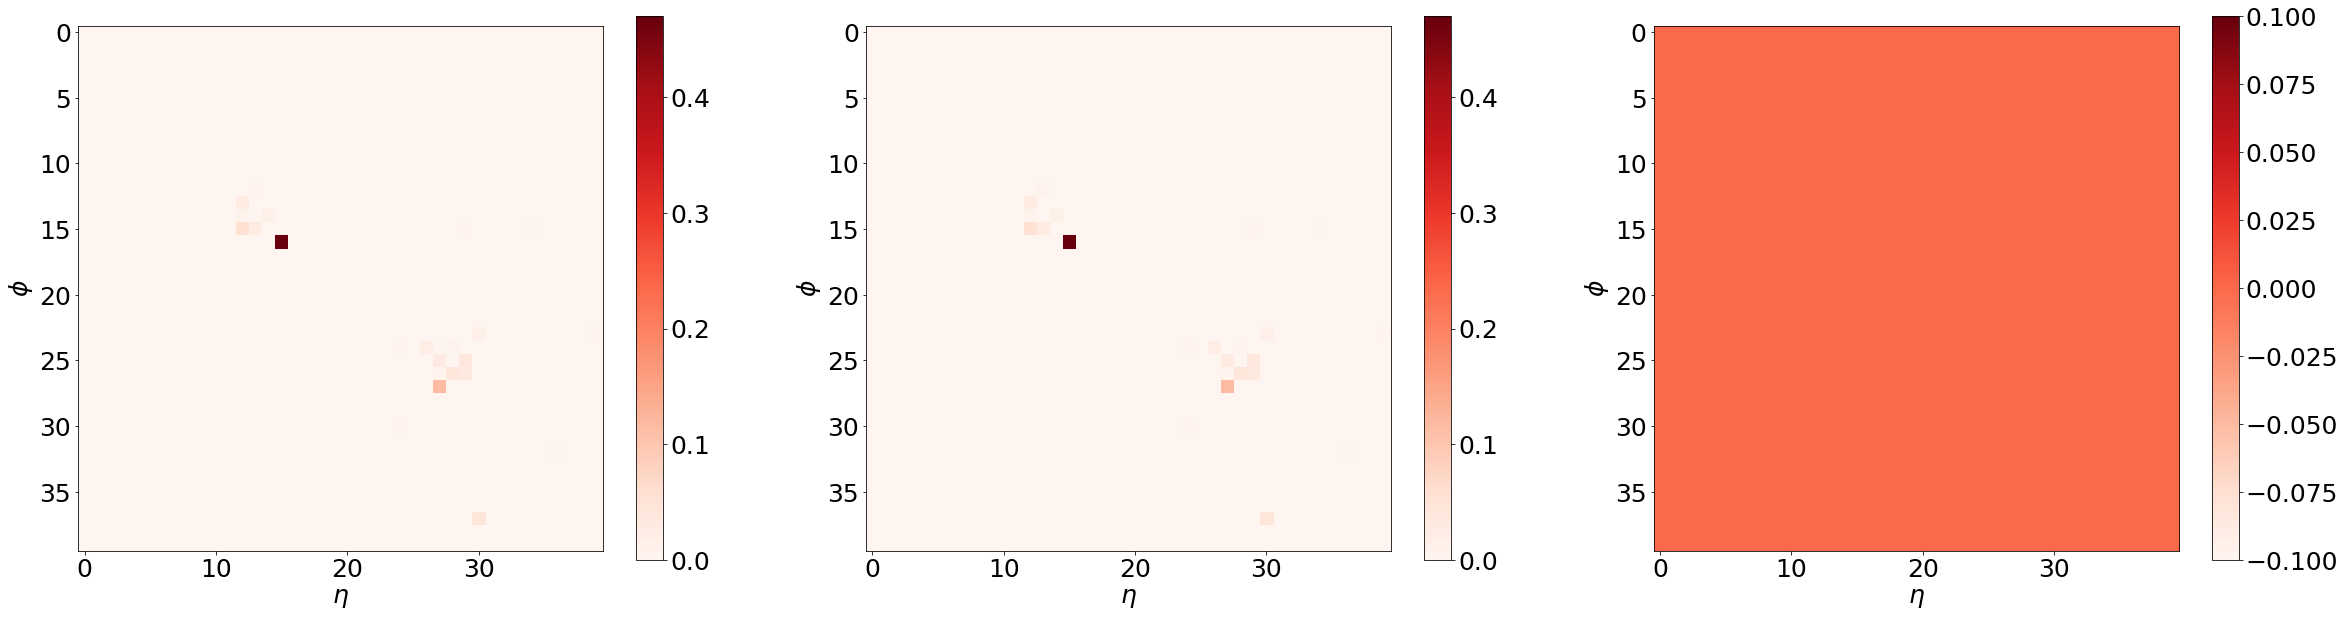

In [45]:
batch_number = 0
n_shift_phi = 0         # number of times shifting failed
n_shift_eta = 0

while process_adversarials(start_number, 1, 1, 1.5, False):
    batch_number += 1
    if batch_number == max_batches:
        break

#Function for data prepraration
pixels = ["img_{0}".format(i) for i in range(1600)]

def to_image(df):
    return  np.expand_dims(np.expand_dims(df[pixels], axis=-1).reshape(-1,40,40), axis=1)
    
print("Data Prepararing Begin")
store_adversarial_images = pandas.HDFStore(f"adversarial.h5")
df_adversarial_images = store_adversarial_images.select("table")
images_adversarial = to_image(df_adversarial_images)
images_adversarial_labels = df_adversarial_images["is_signal_new"].to_numpy()
print("Data Prepararing Finished")

X_adversarial = images_adversarial
y_adversarial = images_adversarial_labels

plotter(X_original, X_adversarial, 'Halt_die_Fresse')

Initial values, Eta = -0.11819329112768173, Phi = -1.8045998811721802, pT = 120.73677062988281
Start values, Eta = -0.11819329112768173, Phi = -1.0, pT = 120.73677062988281
Initial Eta_centroid = 0.041166674345731735, Phi_centroid = 0.13768911361694336
Control Eta_centroid = 0.041166674345731735, Phi_centroid = 0.3035697937011719
After preprocessing, Eta = -0.15935996174812317, Phi = 0.5010300874710083, pT = 120.73677062988281
[    0.05] Finished preprocessing
Data Prepararing Begin
Data Prepararing Finished


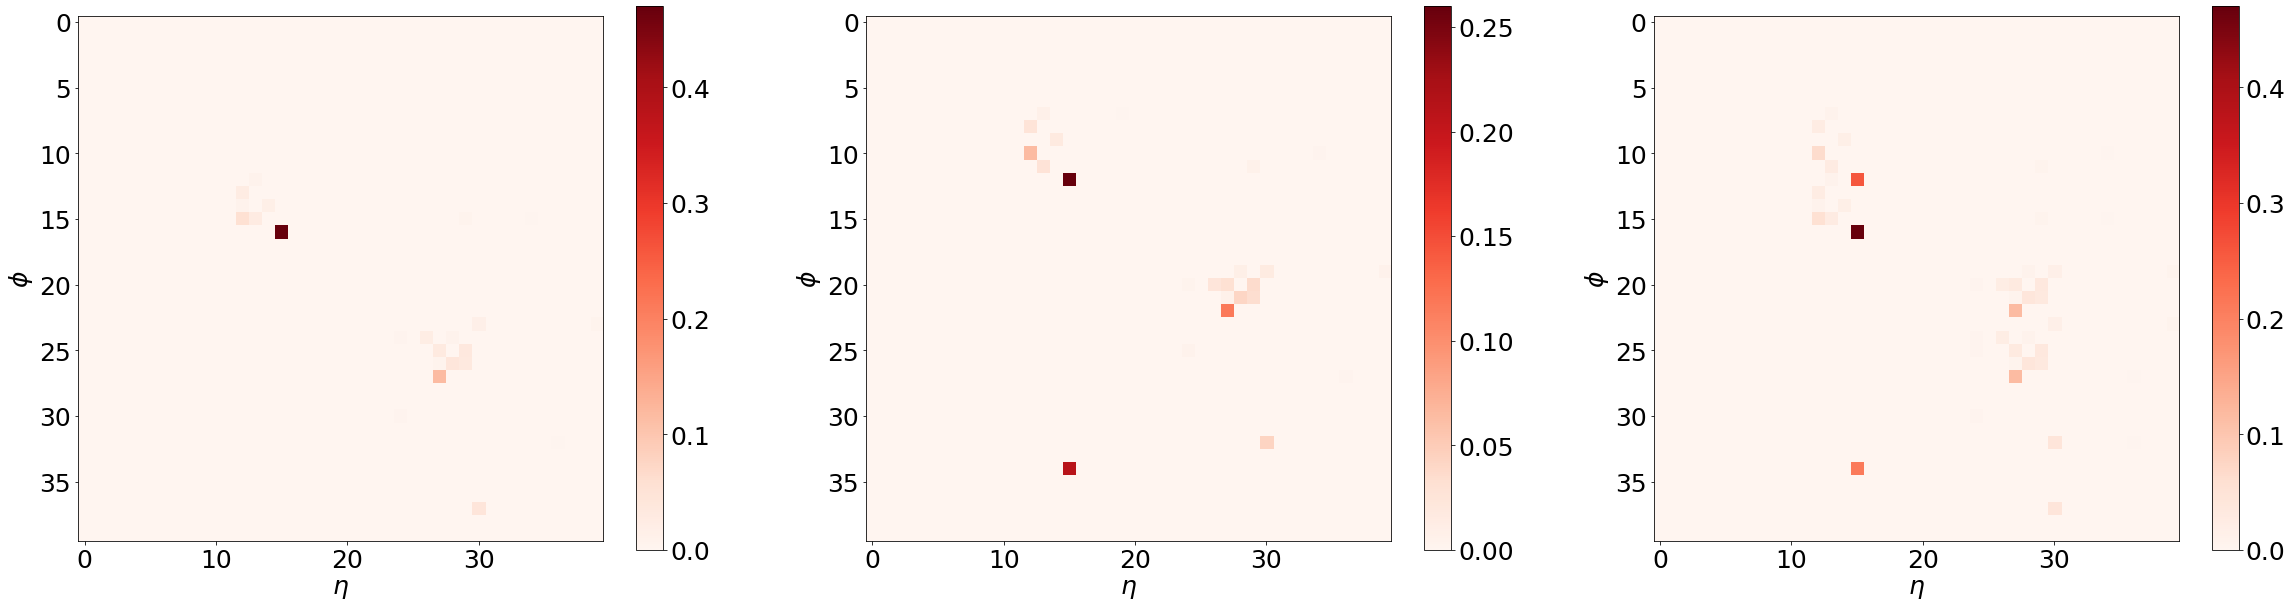

In [46]:
time_start = time.time()
batch_number = 0
n_shift_phi = 0         # number of times shifting failed
n_shift_eta = 0

while process_adversarials(start_number, 1, -0.11819329112768173, -1.0, True): 
    batch_number += 1
    if batch_number == max_batches:
        break
        
if n_shift_eta != 0:
    print_time("Warning: hottest constituent is supposed to be close to origin.")
    print_time("Number of times eta of hottest const. was not close to origin: " + str(n_shift_eta))
if n_shift_phi != 0:
    print_time("Warning: hottest constituent is supposed to be close to origin.")
    print_time("Number of times phi of hottest const. was not close to origin: " + str(n_shift_phi))

print_time("Finished preprocessing")

#Function for data prepraration
pixels = ["img_{0}".format(i) for i in range(1600)]

def to_image(df):
    return  np.expand_dims(np.expand_dims(df[pixels], axis=-1).reshape(-1,40,40), axis=1)
    
print("Data Prepararing Begin")
store_adversarial_images = pandas.HDFStore(f"adversarial.h5")
df_adversarial_images = store_adversarial_images.select("table")
images_adversarial = to_image(df_adversarial_images)
images_adversarial_labels = df_adversarial_images["is_signal_new"].to_numpy()
print("Data Prepararing Finished")

X_adversarial = images_adversarial
y_adversarial = images_adversarial_labels

plotter(X_original, X_adversarial, 'cheated_preprocessing_with_const_centroids')

Initial values, Eta = -0.11819329112768173, Phi = -1.8045998811721802, pT = 120.73677062988281
Start values, Eta = -0.15000000596046448, Phi = -1.9700000286102295, pT = 95.13517761230469
Initial Eta_centroid = 0.041166674345731735, Phi_centroid = 0.13768911361694336
Control Eta_centroid = 0.04304859787225723, Phi_centroid = 0.11588609963655472
After preprocessing_adversarial, Eta = -0.1930485963821411, Phi = -0.28128623962402344, pT = 95.13517761230469
Data Prepararing Begin
Data Prepararing Finished


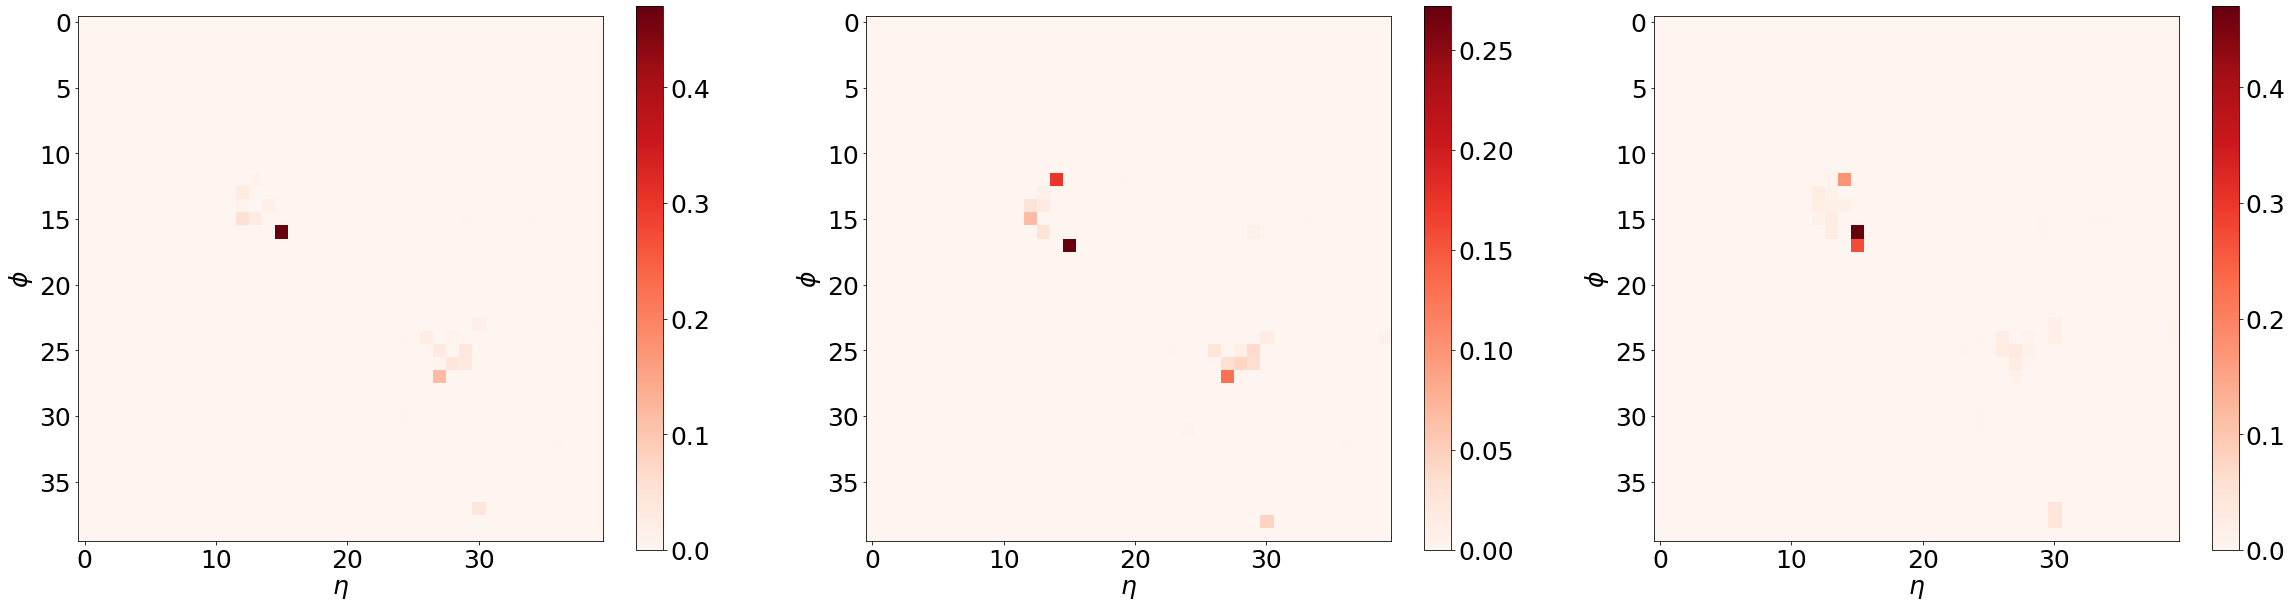

In [47]:
#This is just an experimental setup of an adversarial preprocessing
j = 1
Eta = -0.1499999999999997
Phi = -1.9700000000000069

df = data_store.select('table',start=start_number+0*batch_size,stop=start_number+(1+0)*batch_size)    
feat_list =  ["E","PX","PY","PZ"]
cols = ["{0}_{1}".format(feature,constit)
        for feature in feat_list for constit in range(n_constit)]
vec4 = np.expand_dims(df[cols],axis=-1).reshape(-1, len(feat_list), n_constit)
isig = df[signal_col]

E     = vec4[:,0,:]
pxs   = vec4[:,1,:]
pys   = vec4[:,2,:]
pzs   = vec4[:,3,:]
pT    = np.sqrt(pxs**2+pys**2)

etas  = eta(pT,pzs)
phis  = phi(pxs,pys)

initial_eta = etas[0][j]
initial_phi = phis[0][j]
initial_pT = pT[0][j]

E_tot = E.sum(axis=1)
px_tot = pxs.sum(axis=1)
py_tot = pys.sum(axis=1)
pz_tot = pzs.sum(axis=1)
j_mass = mass(E_tot, px_tot, py_tot, pz_tot)

#pre-shifting of phi
phis = (phis.T - phis[:,0]).T
phis[phis < -np.pi] += 2*np.pi
phis[phis > np.pi] -= 2*np.pi

if intensity == "pT":
    weights = pT
elif intensity == "E":
    weights = E
        
for i in np.arange(0,batch_size):
    eta_centroid = img_mom(etas[i,:], phis[i,:], weights[i,:], 1, 0) / weights[i,:].sum()
    phi_centroid = img_mom(etas[i,:], phis[i,:], weights[i,:], 0, 1)/ weights[i,:].sum()

pT  = np.sqrt(pxs**2+pys**2)
etas  = eta(pT,pzs)
phis  = phi(pxs,pys)

pT[0][j] = (pT[0][j]*etas[0][j])/Eta
etas[0][j] = Eta
phis[0][j] = Phi

print(f'Initial values, Eta = {initial_eta}, Phi = {initial_phi}, pT = {initial_pT}')
print(f'Start values, Eta = {etas[0][j]}, Phi = {phis[0][j]}, pT = {pT[0][j]}')
print(f'Initial Eta_centroid = {eta_centroid}, Phi_centroid = {phi_centroid}')

#pre-shifting of phi
phis = (phis.T - phis[:,0]).T
phis[phis < -np.pi] += 2*np.pi
phis[phis > np.pi] -= 2*np.pi

if intensity == "pT":
    weights = pT
elif intensity == "E":
    weights = E

for i in np.arange(0,batch_size):
    etas[i,:], phis[i,:] = preprocessing(etas[i,:], phis[i,:], weights[i,:])

print(f'After preprocessing_adversarial, Eta = {etas[0][j]}, Phi = {phis[0][j]}, pT = {pT[0][j]}')

# using pT instead of energy E
z_ori = orig_image3(etas, phis, weights)

# normalize
z_new = np.zeros((z_ori.shape[0],n_pixel, n_pixel))
if Norm:
    for i in range(z_ori.shape[0]):
        z_sum = z_ori[i,:,:].sum()
        if z_sum != 0.:
            z_new[i,:,:] = z_ori[i,:,:]/z_sum
        else:
            z_new = z_ori

z_out = z_new.reshape((z_new.shape[0],-1))
out_cols = (["img_{0}".format(i) for i in range(z_new.shape[1]*z_new.shape[2])] + [signal_col] +[mass_col])
df_out = pandas.DataFrame(data=np.concatenate((z_out,isig[:,None],j_mass[:,None]),axis=1), index=np.arange(start_number,start_number+batch_size), columns=out_cols)
if os.path.isfile("adversarial.h5"):
    os.remove("adversarial.h5")
df_out.to_hdf("adversarial.h5",'table',append=(start_number!=0),format='table',complib = "blosc", complevel=5)

#Function for data prepraration
pixels = ["img_{0}".format(i) for i in range(1600)]

def to_image(df):
    return  np.expand_dims(np.expand_dims(df[pixels], axis=-1).reshape(-1,40,40), axis=1)
    
print("Data Prepararing Begin")
store_adversarial_images = pandas.HDFStore(f"adversarial.h5")
df_adversarial_images = store_adversarial_images.select("table")
images_adversarial = to_image(df_adversarial_images)
images_adversarial_labels = df_adversarial_images["is_signal_new"].to_numpy()
print("Data Prepararing Finished")

X_adversarial = images_adversarial
y_adversarial = images_adversarial_labels

plotter(X_original, X_adversarial, 'cheated_preprocessing_with_const_centroids')